# Cohort analysis


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
df = pd.read_excel('./src/data.xlsx', sheet_name=1)
df.head()

,Sale Date,Client ID,Client,Sale ID,Item name,Sales Notes,Location,Notes,Color,Size,Item price (excluding tax),Quantity,Subtotal (excluding tax),Discount %,Discount amount,Tax,Item Total,Total Paid w/ Payment Method,Payment Method
0,2014-12-19,55555рррр,"Client, Test",3,6 sessijas 45min,NaN,[BREEZE} AQUAFIT & VITALITY SPA Center,NaN,---,---,157.03,1,157.03,0.0,0.00,32.97,190.0,190.0,Cash
1,2014-12-19,55555рррр,"Client, Test",3,1 sessija,NaN,[BREEZE} AQUAFIT & VITALITY SPA Center,NaN,---,---,66.11,1,66.11,10.0,6.61,12.50,72.0,72.0,Cash
2,2015-01-05,100000003,"Gromova, Jelena",4,1 sessija 30 min,NaN,[BREEZE} AQUAFIT & VITALITY SPA Center,NaN,---,---,11.16,1,11.16,0.0,0.00,2.34,13.5,13.5,Cash
3,2015-01-05,1,"Walk-in, Walk-in",25,Tēja PUKKA,NaN,[BREEZE} AQUAFIT & VITALITY SPA Center,NaN,---,---,3.72,1,3.72,0.0,0.00,0.78,4.5,4.5,Cash
4,2015-01-05,1,"Walk-in, Walk-in",28,Tēja,NaN,[BREEZE} AQUAFIT & VITALITY SPA Center,NaN,---,---,1.49,1,1.49,16.5,0.25,0.26,1.5,1.5,Cash


## Группировка данных по периоду заказа

In [97]:
df['OrderPeriod'] = df['Sale Date'].apply(lambda x: x.strftime('%Y-%m'))


## Группировка данных по первой покупке клиента

In [98]:
df = df.join(df.groupby(by='Client ID')['OrderPeriod'].min().rename('JoinMonth'), on='Client ID')


## Объединим группы.

In [99]:
cohorts = df.groupby(['JoinMonth', 'OrderPeriod']).aggregate({
    'Client ID': pd.Series.nunique,
    'Item name': pd.Series.count,
    'Item Total': pd.Series.sum
}).rename(columns={
    'Client ID': 'TotalClients', 
    'Item name': 'TotalOrders', 
    'Item Total': 'Revenue'})

cohorts.head(10)

TotalClients  TotalOrders  Revenue
JoinMonth OrderPeriod                                    
2014-12   2014-12                 1            2   262.00
          2015-01                 1            1    15.00
          2015-02                 1            1    22.00
          2016-03                 1            1    50.00
2015-01   2015-01                42          174  3404.80
          2015-02                11           75  1041.15
          2015-03                13           49  1384.24
          2015-04                 7           41   566.40
          2015-05                 5           22   463.10
          2015-06                 4           26   322.17

## Упорядочивание

In [100]:
cohorts = cohorts.join(cohorts.groupby(level=0).cumcount().rename('CohortPeriod'))

## Размер когорты

In [101]:
cohorts = cohorts.reset_index().join(
    cohorts.groupby(level=0)['TotalClients'].first().rename('CohortSize'),
    on='JoinMonth'
)

In [108]:
cohorts.head(10)

,JoinMonth,OrderPeriod,TotalClients,TotalOrders,Revenue,CohortPeriod,CohortSize
0,2014-12,2014-12,1,2,262.00,0,1
1,2014-12,2015-01,1,1,15.00,1,1
2,2014-12,2015-02,1,1,22.00,2,1
3,2014-12,2016-03,1,1,50.00,3,1
4,2015-01,2015-01,42,174,3404.80,0,42
5,2015-01,2015-02,11,75,1041.15,1,42
6,2015-01,2015-03,13,49,1384.24,2,42
7,2015-01,2015-04,7,41,566.40,3,42
8,2015-01,2015-05,5,22,463.10,4,42
9,2015-01,2015-06,4,26,322.17,5,42


In [109]:
cohorts['Retention'] = (cohorts['TotalClients'] / cohorts['CohortSize'] * 100).round()


## Приток пользователь по месяцам первого посящения 


Сколько клиентов присоединилось это значение в соответствующее первому OrderPeriod. То есть в таблице выше мы видим как покупали клиется присоединивщиеся в JoinMonth

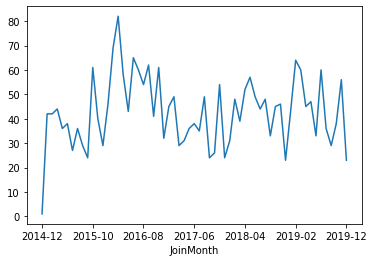

In [103]:
cohorts.groupby('JoinMonth')['CohortSize'].first().plot()

## Считаем Retention

In [107]:
cohorts.set_index(['JoinMonth', 'CohortPeriod'])['TotalClients'].unstack(1)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
JoinMonth,,,,,,,,,,,,,,,,,,,,,
2014-12,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,42.0,11.0,13.0,7.0,5.0,4.0,3.0,4.0,3.0,2.0,...,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0
2015-02,42.0,17.0,7.0,6.0,4.0,2.0,3.0,4.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,44.0,14.0,5.0,3.0,3.0,2.0,5.0,3.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,36.0,12.0,7.0,4.0,1.0,1.0,1.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,36.0,10.0,7.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,29.0,10.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10,38.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В процетах

In [111]:
cohorts.set_index(['JoinMonth', 'CohortPeriod'])['Retention'].unstack(1)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
JoinMonth,,,,,,,,,,,,,,,,,,,,,
2014-12,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,100.0,26.0,31.0,17.0,12.0,10.0,7.0,10.0,7.0,5.0,...,2.0,2.0,2.0,2.0,2.0,7.0,5.0,5.0,2.0,2.0
2015-02,100.0,40.0,17.0,14.0,10.0,5.0,7.0,10.0,5.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,100.0,32.0,11.0,7.0,7.0,5.0,11.0,7.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,100.0,33.0,19.0,11.0,3.0,3.0,3.0,3.0,3.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,100.0,28.0,19.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,100.0,34.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10,100.0,24.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
